# Win prediction for League of Legends games
In this notebook we implement a neural network to predict the outcome of a League of Legends match based purely on the team composition. Our neural network will look roughly like this:

![Neural Network](img/nn.svg)

The input is the champions on the red and blue team, as categorical variables (blue one-hot encoded as +1, red as -1), and there is a two node output predicting which team won, blue or red. 

### The notebook is split into the following parts:
1. Import packages and data
2. Format the data
3. Build the NN
4. Train the NN
5. Evaluate the NN on training and test data
6. Make predictions

### 1. Import packages and data

In [1]:
"""
@author: Mark Bugden
August/September 2022

Part of a ML project in predicting win rates for League of Legends games based on team composition.
Current update available on GitHub: https://github.com/Mark-Bugden
"""

# Import necessary packages
import requests
import pandas as pd
from ratelimit import limits, sleep_and_retry
import pickle
import math
import numpy as np
from matplotlib import pyplot as plt
import os
import glob


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

# This gives us a progress bar for longer computations. 
from tqdm.notebook import tqdm
# To use it, just wrap any iterable with tqdm(iterable).
# Eg: 
# for i in tqdm(range(100)):
#     ....

# Here are the tiers and divisions
tier_list = ['DIAMOND', 'PLATINUM', 'GOLD', 'SILVER', 'BRONZE', 'IRON']
division_list = ['I', 'II', 'III', 'IV']

# Load the champion information
champion_url = 'http://ddragon.leagueoflegends.com/cdn/12.14.1/data/en_US/champion.json'
r = requests.get(champion_url)
json_data = r.json()
champion_data = json_data['data']

champions = list(champion_data.keys())

# For some reason Fiddlesticks is listed as FiddleSticks in some of the other data. To avoid problems like this, I will convert all champion names to lowercase
champions = [champ.lower() for champ in champions]


champ_to_num = {k: v for v, k in enumerate(champions)}
num_to_champ = {v: k for v, k in enumerate(champions)}

# We can get champion information by accessing the champion_data dict
# Eg:
# champion_data['Zyra']

In [2]:
# Load the csv file produced in the Get_Match_Data iPython notebook
rankeddf = pd.read_csv('Data collection/ranked_matches.csv') 

# Convert the champion names to lower as well to match up with our champions list.
rankeddf['championName'] = rankeddf['championName'].str.lower()

### 2. Format the data

In [3]:
# Here are three matches
rankeddf.head(30)

,matchId,team,win,championName,summonerName,gameMode
0,EUN1_3113399031,Blue,False,sion,Cycuch2115,420
1,EUN1_3113399031,Blue,False,khazix,1UseRNmE2,420
2,EUN1_3113399031,Blue,False,katarina,sufloW,420
3,EUN1_3113399031,Blue,False,ashe,SONA FAKER,420
4,EUN1_3113399031,Blue,False,nautilus,S0lstice,420
5,EUN1_3113399031,Red,True,mordekaiser,Jhetro,420
6,EUN1_3113399031,Red,True,lillia,thanasis0016,420
7,EUN1_3113399031,Red,True,yasuo,PM FOR PERMABAN,420
8,EUN1_3113399031,Red,True,lucian,mathejn,420
9,EUN1_3113399031,Red,True,renata,banelbi,420


In [4]:
# One hot encode a list of champions
def onehotencodechampions(champs):
    ''' One hot encodes a list of champions.
    
    
    '''
    integer_encoded = [champ_to_num[champ] for champ in champs]
    onehot_encoded = [0] * len(champions)
    for value in integer_encoded:
        onehot_encoded[value] = 1
    return onehot_encoded

In [5]:
# We will now put the data into the format we will use for training and testing. This will consist of two lists - the first will be features, and the second will be labels.
# For the features list, each element of the list corresponds to a game, and that element will itself be a list of the champions in that game one-hot-encoded.
# Blue team champions being represented by +1 and red team by -1.

# For the labels list, each element will again be a game, and that element will be a one-hot encoded list of two elements. [1,0] for a blue win, and [0,1] for a red win.

matches = rankeddf['matchId'].unique().tolist()

features = []
labels = []

for match in matches:
    blueteam = rankeddf[(rankeddf['matchId'] == match) & (rankeddf['team'] == 'Blue')]['championName'].tolist()
    redteam = rankeddf[(rankeddf['matchId'] == match) & (rankeddf['team'] == 'Red')]['championName'].tolist()
    
    blueteam = onehotencodechampions(blueteam)
    redteam = [value*-1 for value in onehotencodechampions(redteam)]
    
    features.append([sum(value) for value in zip(blueteam, redteam)])
    
    # We only need to check one champion
    if rankeddf[(rankeddf['matchId'] == match) & (rankeddf['team'] == 'Blue')].iloc[0]['win'] == True:
        labels.append([1,0])
    else:
        labels.append([0,1])
    
    
    # Since we are interested in team composition regardless of whether the team is red or blue, we can double the matches by swapping champs and winners
    # That is, champion data swaps +1 and -1, and winner swaps [1,0] and [0,1]. We then randomly select matches later for testing and training.
    
    features.append([-1*sum(value) for value in zip(blueteam, redteam)])
    if rankeddf[(rankeddf['matchId'] == match) & (rankeddf['team'] == 'Blue')].iloc[0]['win'] == True:
        labels.append([0,1])
    else:
        labels.append([1,0])
    
    

features = np.array(features)        
labels = np.array(labels)

In [6]:
# Split the data into training, validation, and test data


#train_features = features[0 :math.floor(0.7*len(matches))]
#train_labels = labels[0 : math.floor(0.7*len(matches))]

#validation_features = features[math.floor(0.7*len(matches)) : math.floor(0.9*len(matches))]
#validation_labels = labels[math.floor(0.7*len(matches)) : math.floor(0.9*len(matches))]

#test_features = features[math.floor(0.9*len(matches)) : ]
#test_labels = labels[math.floor(0.9*len(matches)) : ]



train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.3, random_state=41)

### 3. Build the NN

In [7]:
# Define the keras model

num_hidden_layers = 8
num_neurons_per_layer = 128

model = tf.keras.Sequential()


# Some useful variables
model.num_hidden_layers = num_hidden_layers
model.num_neurons_per_layer = num_neurons_per_layer


# Input dimension is the number of champions (currently 161)
model.add(tf.keras.Input(len(champion_data)))

# Append hidden layers
for _ in range(num_hidden_layers):
    model.add(tf.keras.layers.Dense(num_neurons_per_layer,
        activation=tf.keras.activations.get('relu'),
        kernel_initializer='HeNormal', name='HiddenLayer'+str(_+1)))

# Output is two-dimensional
model.add(tf.keras.layers.Dense(2, name='Output'))


loss_fn = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HiddenLayer1 (Dense)        (None, 128)               20736     
                                                                 
 HiddenLayer2 (Dense)        (None, 128)               16512     
                                                                 
 HiddenLayer3 (Dense)        (None, 128)               16512     
                                                                 
 HiddenLayer4 (Dense)        (None, 128)               16512     
                                                                 
 HiddenLayer5 (Dense)        (None, 128)               16512     
                                                                 
 HiddenLayer6 (Dense)        (None, 128)               16512     
                                                                 
 HiddenLayer7 (Dense)        (None, 128)               1

### 4. Train the network

In [9]:
history = model.fit(train_features, train_labels, batch_size = 20, epochs=20)

Epoch 1/20
109/109 [==============================] - 2s 5ms/step - loss: 0.8004 - accuracy: 0.5002
Epoch 2/20
109/109 [==============================] - 1s 5ms/step - loss: 0.6864 - accuracy: 0.5769
Epoch 3/20
109/109 [==============================] - 1s 5ms/step - loss: 0.6854 - accuracy: 0.5802
Epoch 4/20
109/109 [==============================] - 1s 5ms/step - loss: 0.6470 - accuracy: 0.6514
Epoch 5/20
109/109 [==============================] - 1s 5ms/step - loss: 0.6079 - accuracy: 0.7474
Epoch 6/20
109/109 [==============================] - 1s 5ms/step - loss: 0.6018 - accuracy: 0.7542
Epoch 7/20
109/109 [==============================] - 1s 5ms/step - loss: 0.5164 - accuracy: 0.8195
Epoch 8/20
109/109 [==============================] - 1s 5ms/step - loss: 0.7082 - accuracy: 0.7836
Epoch 9/20
109/109 [==============================] - 1s 6ms/step - loss: 0.7016 - accuracy: 0.7437
Epoch 10/20
109/109 [==============================] - 1s 6ms/step - loss: 0.3944 - accuracy: 0.8774

### 5. Evaluate the network on the training and test data

In [10]:
model.evaluate(train_features, train_labels, verbose=2)

69/69 - 0s - loss: 0.0976 - accuracy: 0.9890 - 355ms/epoch - 5ms/step


[0.097592294216156, 0.9889756441116333]

In [11]:
model.evaluate(test_features, test_labels, verbose=2)

30/30 - 0s - loss: 5.4064 - accuracy: 0.4962 - 107ms/epoch - 4ms/step


[5.4064249992370605, 0.49624866247177124]

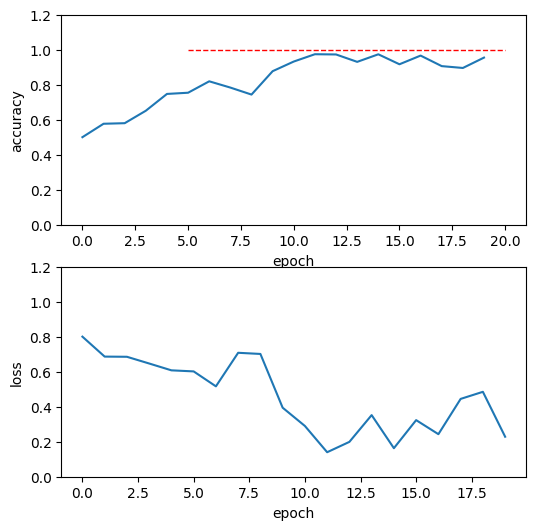

In [12]:
fig, ax = plt.subplots(2,1, figsize=(6, 6))

ax[0].plot(history.history['accuracy'])
ax[0].hlines(y=1, xmin=5, xmax=20, colors='red', linestyles='--', lw=1)

ax[1].plot(history.history['loss'])

ax[0].set_xlabel('epoch')
ax[1].set_xlabel('epoch')

ax[0].set_ylabel('accuracy')
ax[1].set_ylabel('loss')

ax[0].set_ylim(0, 1.2)
ax[1].set_ylim(0, 1.2)


plt.show()

### 6. Make predictions

We will now predict the winner of a random match of champions. 

In [19]:
# Pick a random selection of champions

pred_champs = np.random.choice(161, 10, replace=False)
pred_blue_champs = pred_champs[0:5]
pred_red_champs = pred_champs[5:]

pred_blue_team = [num_to_champ[champ] for champ in pred_blue_champs]
pred_red_team = [num_to_champ[champ] for champ in pred_red_champs]

print('Blue team is: ', pred_blue_team)
print('Red team is: ', pred_red_team)

Blue team is:  ['caitlyn', 'karma', 'jayce', 'qiyana', 'draven']
Red team is:  ['braum', 'riven', 'twistedfate', 'xerath', 'warwick']


In [20]:
pred_features = []

pred_blue_team_enc = onehotencodechampions(pred_blue_team)
pred_red_team_enc = [value*-1 for value in onehotencodechampions(pred_red_team)]

pred_features.append([sum(value) for value in zip(pred_blue_team_enc, pred_red_team_enc)])
pred_features = np.array(pred_features)

pred_outcome = tf.nn.softmax(model(pred_features)).numpy()

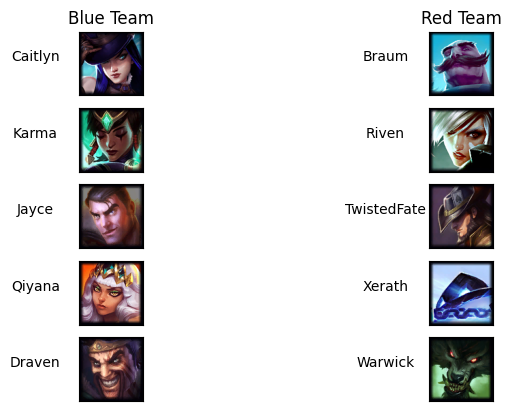

RED team is the predicted winner 

Blue win probability:  0.28637567
Red win probability:  0.7136243


In [21]:
from matplotlib.image import imread

imgarrays = [imread(file) for file in glob.glob('img/Champion icons/*')]
champ_list = [champ for champ in champion_data.keys()]



fig, ax = plt.subplots(5,3)

for i in range(5):
    ax[i,0].imshow(imgarrays[champ_to_num[pred_blue_team[i]]])
    ax[i,0].set_ylabel(champ_list[champ_to_num[pred_blue_team[i]]], rotation=0, fontsize='medium', labelpad=28)
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    
for i in range(5):
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])
    ax[i,1].axis('off')

for i in range(5):
    ax[i,2].imshow(imgarrays[champ_to_num[pred_red_team[i]]])
    ax[i,2].set_ylabel(champ_list[champ_to_num[pred_red_team[i]]], rotation=0, size='medium', labelpad=28)
    ax[i,2].set_xticks([])
    ax[i,2].set_yticks([])
    
ax[0,0].set_title('Blue Team')
ax[0,2].set_title('Red Team')

plt.show()


# The predicted winner
if (pred_outcome.argmax()==0):
    print('BLUE team is the predicted winner', '\n')
    print('Blue win probability: ', pred_outcome[0][0])
    print('Red win probability: ', pred_outcome[0][1])
    
elif (pred_outcome.argmax()==1):
    print('RED team is the predicted winner', '\n')
    print('Blue win probability: ', pred_outcome[0][0])
    print('Red win probability: ', pred_outcome[0][1])
    
else:
    print('Something went wrong!', '\n')
    print('Blue win probability: ', pred_outcome[0][0])
    print('Red win probability: ', pred_outcome[0][1])
